In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from glob import glob

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import XML2Dict

In [4]:
%matplotlib notebook

### Get meta data from files

In [5]:
data_folder = r'F:\EEG_exp\mouse569073\estim_vis_2021-04-15_10-27-22\experiment1\recording1' # signal chain 2
exp = EEGexp(data_folder, preprocess=False)

Experiment type: electrical and sensory stimulation


In [6]:
print(exp.mouse)
print(exp.ephys_params['EEG']['sample_rate'])
print(exp.computerID)
print(exp.ephys_params['EEG']['num_chs'])

569073
2500
W10DT05491
40


In [7]:
TARGET_SAMPLE_RATE = 100 # Hz
# the actual scale is 10% = 4.095 V
PER_VOLTS = 10./4.095

## Analog iso signal from OpenEphys

exp.load_eegdata(): during preprocessing step cuts array down to 32 chs
<br>exp._memmap_EEGdata(): the memmap step re-orders the data via the intan eeg map which cuts the array down to 32 chs

In [8]:
# hard-coding these values because the settings file names change
iso_level_ind = int(32) # index of analog channel 1 from OpenEphys
iso_level_gain = 0.000152587890625 # bits to volts factor from OpenEphys
downsamplefactor = int(exp.ephys_params['EEG']['sample_rate'] / TARGET_SAMPLE_RATE)

In [9]:
raw_cont = np.memmap(exp.ephys_params['EEG']['continuous'], dtype='int16', mode='r')
raw_cont = raw_cont.reshape((int(raw_cont.size/exp.ephys_params['EEG']['num_chs']), exp.ephys_params['EEG']['num_chs']))
print(raw_cont.shape)

(26812672, 40)


In [10]:
iso_signal = raw_cont[:, iso_level_ind] * iso_level_gain * PER_VOLTS
if os.path.exists(exp.ephys_params['EEG']['timestamps']):
    start_time = np.load(exp.ephys_params['EEG']['timestamps'])[0]
else:
    start_time = 0.0
print(start_time)
timex = (np.arange(0, len(iso_signal)) / exp.ephys_params['EEG']['sample_rate']) + start_time

46.0410947531459


In [11]:
## Downsample both ##
iso_ds = iso_signal[0::downsamplefactor]
time_ds = timex[0::downsamplefactor]

<IPython.core.display.Javascript object>


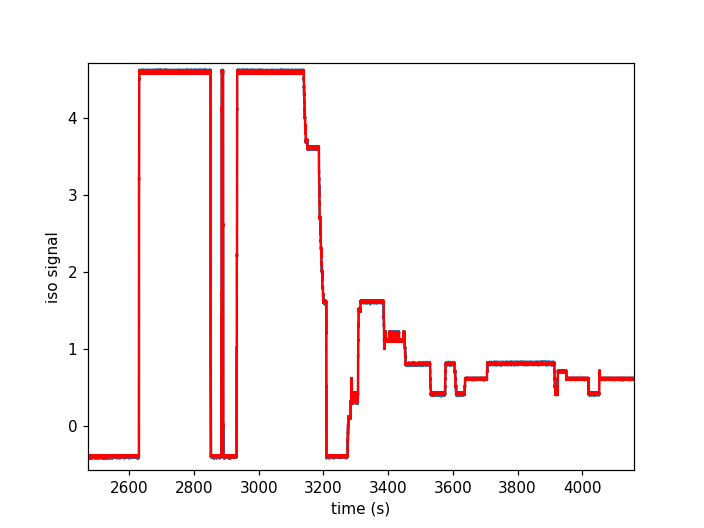

Text(0.5, 0, 'time (s)')

In [12]:
fig, ax = plt.subplots()
ax.plot(timex, iso_signal)
ax.plot(time_ds, iso_ds, color='r')
ax.set_ylabel('iso signal')
ax.set_xlabel('time (s)')

In [16]:
iso_sig = raw_cont[0::ds_factor, 33] * iso_gain
# iso_sig = raw_cont[:, 33]
analogx = np.arange(0, len(iso_sig)) / TARGET_SAMPLE_RATE
print(len(iso_sig))

98895113


<IPython.core.display.Javascript object>


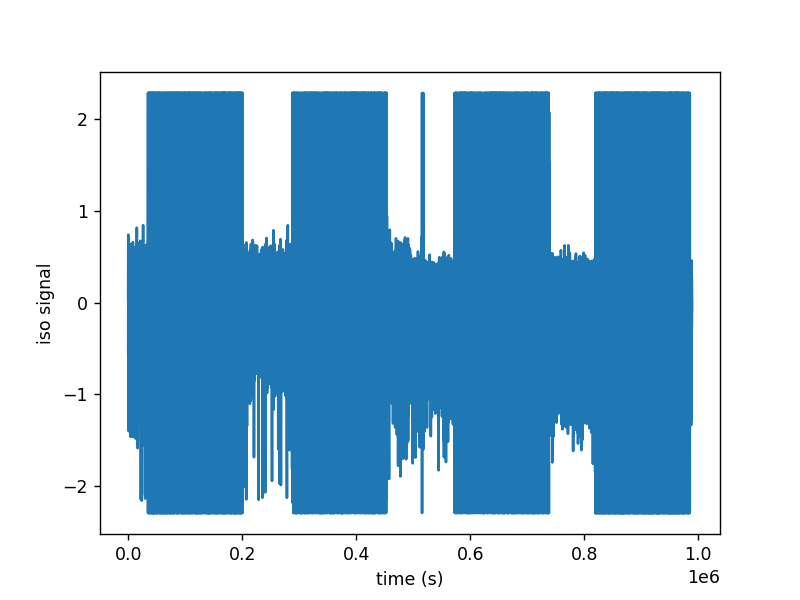

Text(0.5, 0, 'time (s)')

In [17]:
fig, ax = plt.subplots()
ax.plot(analogx, iso_sig*PER_VOLTS)
ax.set_ylabel('iso signal')
ax.set_xlabel('time (s)')

In [15]:
# make analog arrays into pandas Series
iso = pd.Series(data=iso_ds, index=time_ds, name='iso_level')
iso.head()

46.041095   -0.380445
46.051095   -0.380445
46.061095   -0.393487
46.071095   -0.386407
46.081095   -0.383426
Name: iso_level, dtype: float64

In [18]:
iso[iso > 4.5]

2630.051095    4.508329
2630.061095    4.508329
2630.071095    4.505348
2630.081095    4.508329
2630.091095    4.504976
                 ...   
5919.661095    4.603720
5919.671095    4.615644
5919.681095    4.603347
5919.691095    4.615644
5919.701095    4.602602
Name: iso_level, Length: 45994, dtype: float64

In [19]:
iso_start = iso[iso > 4.5].index[0]

In [22]:
poss_induction = iso[iso_start:iso_start+900]

In [23]:
iso_end = poss_induction[poss_induction > 4.5].index[-1]
iso_end

3139.591094753146

In [24]:
iso_max_times = (iso_start, iso_end)
# iso_maint_times = (
#     iso[(iso > 1.8) & (iso < 2.2) & (iso.index > iso_max_times[1])].index[0],
#     iso[(iso > 1.8) & (iso < 2.2) & (iso.index > iso_max_times[1])].index[-1]
# )
iso_maint_times = (
    iso[(iso > 0.2) & (iso < 4.5) & (iso.index > iso_max_times[1])].index[0],
    iso[(iso > 0.2) & (iso < 4.5) & (iso.index > iso_max_times[1])].index[-1]
)
print(iso_max_times)
print(iso_maint_times)

(2630.051094753146, 3139.591094753146)
(3139.601094753146, 6719.221094753146)


<IPython.core.display.Javascript object>


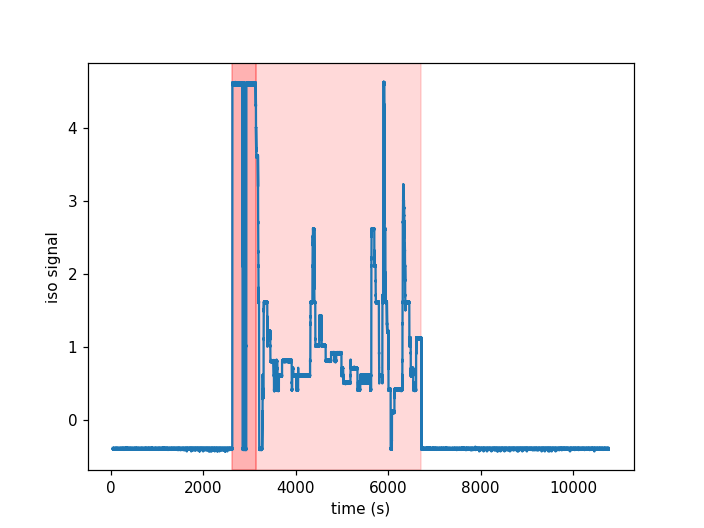

Text(0.5, 0, 'time (s)')

In [25]:
fig, ax = plt.subplots()
ax.plot(time_ds, iso_ds)
ax.axvspan(iso_max_times[0], iso_max_times[1], color='r', alpha=0.3)
ax.axvspan(iso_maint_times[0], iso_maint_times[1], color='r', alpha=0.15)
ax.set_ylabel('iso signal')
ax.set_xlabel('time (s)')

## Analog iso signal from sync gui

Load sync dataset

In [10]:
sync_dataset = exp._load_sync_dataset()

In [11]:
print(sync_dataset.line_labels)

['barcodes', 'estim_sweep', 'frames', '', 'photodiode', 'sweep', '', '', 'eyetracking', 'behavior', 'rotA', 'rotB', '', '', '', '', '', 'opto_sweep', 'opto_trial', '', '', '', '', '', '', '', '', '', '', '', '', 'estim_sync']


In [13]:
iso_sig = sync_dataset.get_analog_channel('iso_level')[0::ds_factor]
print(len(iso_sig))

KeyError: 'No analog data was saved.'

In [13]:
analogx = np.arange(0, len(iso_sig)) / TARGET_SAMPLE_RATE

<IPython.core.display.Javascript object>


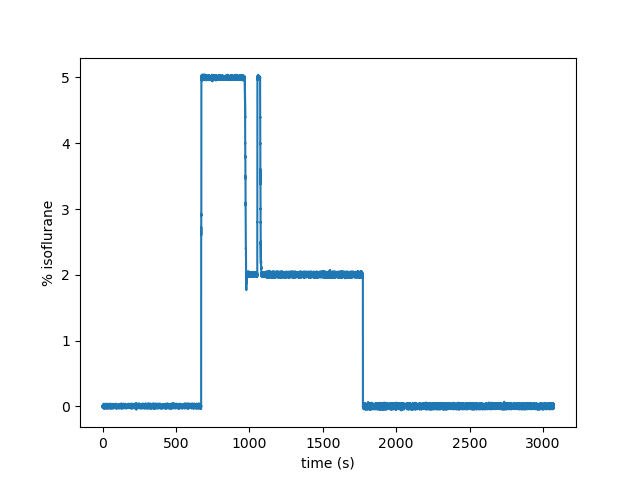

Text(0.5, 0, 'time (s)')

In [14]:
fig, ax = plt.subplots()
ax.plot(analogx, iso_sig*PER_VOLTS)
ax.set_ylabel('% isoflurane')
ax.set_xlabel('time (s)')

Extract on/off times

In [20]:
# make analog arrays into pandas Series
iso = pd.Series(data=iso_sig*PER_VOLTS, index=analogx, name='iso_level')
iso.head()

0.00   -0.000405
0.01    0.005884
0.02    0.003526
0.03    0.005884
0.04    0.003526
Name: iso_level, dtype: float64

In [22]:
iso_max_times = (
    iso[iso > 4.9].index[0],
    iso[iso > 4.9].index[-1]
)
iso_maint_times = (
    iso[(iso > 1.8) & (iso < 2.2) & (iso.index > iso_max_times[1])].index[0],
    iso[(iso > 1.8) & (iso < 2.2) & (iso.index > iso_max_times[1])].index[-1]
)

In [27]:
print(iso_max_times)
print(iso_maint_times)

(673.13, 1073.08)
(1078.29, 1773.0)


<IPython.core.display.Javascript object>


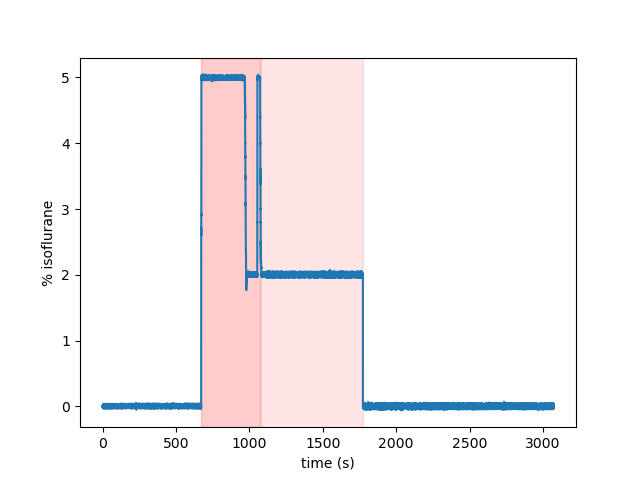

Text(0.5, 0, 'time (s)')

In [29]:
fig, ax = plt.subplots()
ax.plot(analogx, iso_sig*PER_VOLTS)
ax.axvspan(iso_max_times[0], iso_max_times[1], color='r', alpha=0.3)
ax.axvspan(iso_maint_times[0], iso_maint_times[1], color='r', alpha=0.15)
ax.set_ylabel('% isoflurane')
ax.set_xlabel('time (s)')